In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
data_apple = pd.read_csv("AAPL.csv", index_col='date', parse_dates=['date'])
data_apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9669 entries, 2019-04-18 to 1980-12-12
Data columns (total 6 columns):
volume      9669 non-null int64
open        9669 non-null float64
close       9669 non-null float64
high        9669 non-null float64
low         9669 non-null float64
adjclose    9669 non-null float64
dtypes: float64(5), int64(1)
memory usage: 528.8 KB


In [123]:
data_apple.head()

,volume,open,close,high,low,adjclose
date,,,,,,
2019-04-18,24195800,203.119995,203.860001,204.149994,202.520004,203.860001
2019-04-17,28906800,199.539993,203.130005,203.380005,198.610001,203.130005
2019-04-16,25696400,199.460007,199.250000,201.369995,198.559998,199.250000
2019-04-15,17536600,198.580002,199.229996,199.850006,198.009995,199.229996
2019-04-12,27760700,199.199997,198.869995,200.139999,196.210007,198.869995


In [124]:
data_apple.tail()

,volume,open,close,high,low,adjclose
date,,,,,,
1980-12-18,18362400,0.475446,0.475446,0.477679,0.475446,0.021307
1980-12-17,21610400,0.462054,0.462054,0.464286,0.462054,0.020706
1980-12-16,26432000,0.453125,0.450893,0.453125,0.450893,0.020206
1980-12-15,43971200,0.488839,0.486607,0.488839,0.486607,0.021807
1980-12-12,117258400,0.513393,0.513393,0.515625,0.513393,0.023007


In [147]:
#Since our dataset starts from 2019 to 1980, we want to reverse it
reversed_data_apple = data_apple.iloc[::-1]

,volume,open,close,high,low,adjclose
date,,,,,,
1980-12-12,117258400,0.513393,0.513393,0.515625,0.513393,0.023007
1980-12-15,43971200,0.488839,0.486607,0.488839,0.486607,0.021807
1980-12-16,26432000,0.453125,0.450893,0.453125,0.450893,0.020206
1980-12-17,21610400,0.462054,0.462054,0.464286,0.462054,0.020706
1980-12-18,18362400,0.475446,0.475446,0.477679,0.475446,0.021307
1980-12-19,12157600,0.504464,0.504464,0.506696,0.504464,0.022607
1980-12-22,9340800,0.529018,0.529018,0.531250,0.529018,0.023707
1980-12-23,11737600,0.551339,0.551339,0.553571,0.551339,0.024708
1980-12-24,12000800,0.580357,0.580357,0.582589,0.580357,0.026008


In [213]:
training_set = reversed_data_apple['2006':'2017'].iloc[:,3:4].values
test_set = reversed_data_apple['2018':].iloc[:,3:4].values

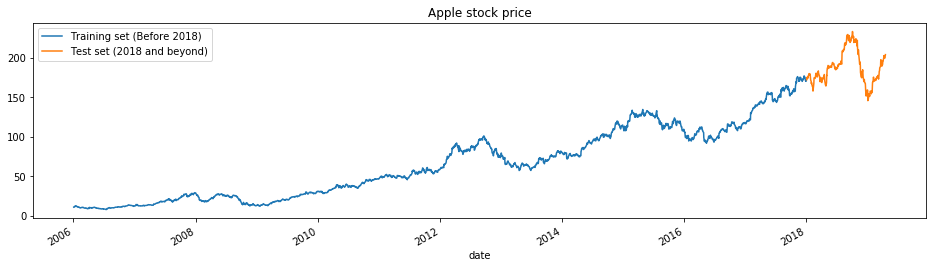

In [214]:
reversed_data_apple["high"]['2006':'2017'].plot(figsize=(16,4),legend=True)
reversed_data_apple["high"]['2018':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('Apple stock price')
plt.show()

We chose Apple as the target company for our project. We have 9669 entries and 6 features in this Apple dataset, but we are not going to use them all. We have chosen 'High' for predicting prices.

In [215]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [216]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
apple_training_scaled  = sc.fit_transform(training_set)

In [257]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []

previous = 30

for i in range(previous, len(apple_training_scaled)):
    X_train.append(apple_training_scaled[i-previous:i,0])
    y_train.append(apple_training_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [258]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(2990, 30, 1)

In [259]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
2990/2990 [==============================] - 17s 6ms/step - loss: 0.0142
Epoch 2/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0024
Epoch 3/50
2990/2990 [==============================] - 9s 3ms/step - loss: 0.0025
Epoch 4/50
2990/2990 [==============================] - 9s 3ms/step - loss: 0.0020
Epoch 5/50
2990/2990 [==============================] - 9s 3ms/step - loss: 0.0018
Epoch 6/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0017
Epoch 7/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0017
Epoch 8/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0017
Epoch 9/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0019
Epoch 10/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0017
Epoch 11/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0014
Epoch 12/50
2990/2990 [==============================] - 9s 3ms/step - loss: 0.0016


In [264]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 30 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
data_apple_total = pd.concat((reversed_data_apple["high"][:'2017'],reversed_data_apple["high"]['2018':]),axis=0)
inputs = data_apple_total[len(data_apple_total) - len(test_set) - previous:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [265]:
# Preparing X_test and predicting the prices
X_test = []

for i in range(previous, len(inputs)):
    X_test.append(inputs[i-previous:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

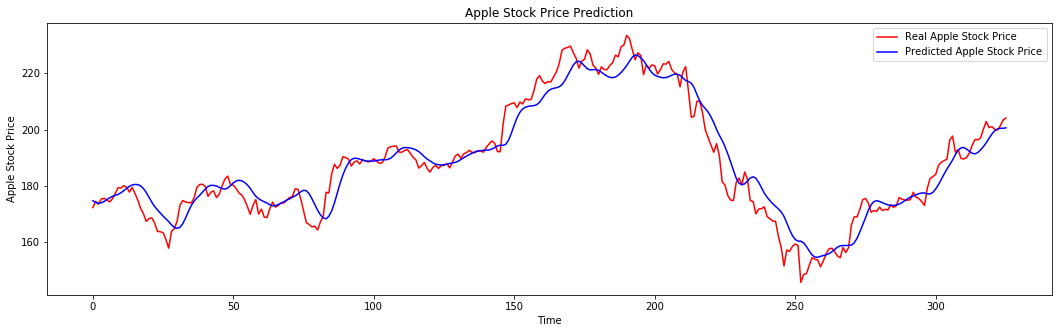

In [266]:
# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real '+ 'Apple Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted '+'Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [267]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 5.458139145919085.


In the graph, it seems like there is a delay in this prediction, which is right since there is a typical problem in LSTM for time series prediction(1-step lag predictor). The possible solution for it is **do not give the prices directly** to the algorithm. The point is do not give direct intuition to what it should predict, only provide patterns for algorithm to work on. So we will start to make a new data preprocessing.